In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import spatial_maps as sp
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
import expipe
import os
import pathlib
import numpy as np
import exdir
import pandas as pd
import optogenetics as og
import quantities as pq
import shutil
from distutils.dir_util import copy_tree

from septum_mec.analysis.stimulus_response import stimulus_response_latency, compute_response

from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

08:31:41 [I] klustakwik KlustaKwik2 version 0.2.6


In [3]:
std_gaussian_kde = 0.04
window_size = 0.03

In [4]:
data_loader = dp.Data()
actions = data_loader.actions
project = data_loader.project

In [5]:
output = pathlib.Path('output/stimulus-response')
(output / 'figures').mkdir(parents=True, exist_ok=True)

In [6]:
identify_neurons = actions['identify-neurons']
units = pd.read_csv(identify_neurons.data_path('units'))

In [7]:
def process(row):
    
    action_id = row['action']
    channel_id = int(row['channel_group'])
    unit_id = int(row['unit_name'])    
    
    spike_times = data_loader.spike_train(action_id, channel_id, unit_id)
    
    spike_times = np.array(spike_times)
    
    stim_times = data_loader.stim_times(action_id)
    
    nan_series = pd.Series({
            't_e_peak': np.nan,
            'p_e_peak': np.nan,
            't_i_peak': np.nan,
            'p_i_peak': np.nan
        })
    
    if stim_times is None:
        return nan_series
    
    stim_times = np.array(stim_times)
    
    times, spikes, kernel, p_e, p_i = stimulus_response_latency(
        spike_times, stim_times, window_size, std_gaussian_kde)
    
    # if no spikes detected after stimulus nan is returned
    if all(np.isnan([p_e, p_i])):
        return nan_series
        
    t_e_peak, p_e_peak, t_i_peak, p_i_peak = compute_response(
        spike_times, stim_times, times, kernel, p_e, p_i)

    return pd.Series({
        't_e_peak': t_e_peak,
        'p_e_peak': p_e_peak,
        't_i_peak': t_i_peak,
        'p_i_peak': p_i_peak
    })




In [8]:
results = units.merge(
    units.progress_apply(process, axis=1), 
    left_index=True, right_index=True)

/home/mikkel/apps/expipe-project/septum-mec/septum_mec/analysis/stimulus_response.py:33: RuntimeWarning: invalid value encountered in less
  if any(times[idxs_i] < te_peak):


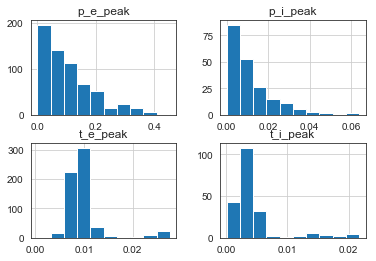

In [9]:
results.loc[:, ['t_e_peak', 't_i_peak', 'p_e_peak', 'p_i_peak']].hist()
plt.gcf().savefig(output / 'figures' / 'summary_histogram.png')

# Save to expipe

In [10]:
action = project.require_action("stimulus-response")

In [11]:
action.modules['parameters'] = {
    'window_size': window_size,
    'std_gaussian_kde': std_gaussian_kde
}

In [12]:
action.data['results'] = 'results.csv'
results.to_csv(action.data_path('results'), index=False)

In [13]:
stuff = {
    "figures": "figures",
#     "statistics": "statistics"
}

for key, value in stuff.items():
    action.data[key] = value
    data_path = action.data_path(key)
    data_path.parent.mkdir(exist_ok=True, parents=True)
    source = output / value
    if source.is_file():
        shutil.copy(source, data_path)
    else:
        copy_tree(str(source), str(data_path))

In [14]:
septum_mec.analysis.registration.store_notebook(action, "10-calculate-stimulus-response.ipynb")